In [1]:
import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

np.random.seed(42)

# Etude 1 - Training a Classifier for the SketchRNN Dataset

Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets (https://github.com/googlecreativelab/quickdraw-dataset).

Let's create the dataset with the list of files. You can either use the locally-stored dataset or make Google Colab download it automatically. 

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
dataset_dir = os.path.join(os.getcwd(), "dataset_rnn")

# create new directory
if not os.path.isdir(dataset_dir):
    os.mkdir(dataset_dir)

In [4]:
tfrecords_dir = os.path.join(os.getcwd(), "dataset_rnn", "tfrecords")

# create new directory
if not os.path.isdir(tfrecords_dir):
    os.mkdir(tfrecords_dir)

In [5]:
# downloads the dataset
!gsutil cp gs://quickdraw_dataset/full/numpy_bitmap/airplane.npy dataset_rnn/airplane.npy
!gsutil cp gs://quickdraw_dataset/full/numpy_bitmap/apple.npy dataset_rnn/apple.npy
!gsutil cp gs://quickdraw_dataset/full/numpy_bitmap/bridge.npy dataset_rnn/bridge.npy
!gsutil cp gs://quickdraw_dataset/full/numpy_bitmap/guitar.npy dataset_rnn/guitar.npy
!gsutil cp gs://quickdraw_dataset/full/numpy_bitmap/mushroom.npy dataset_rnn/mushroom.npy

Copying gs://quickdraw_dataset/full/numpy_bitmap/airplane.npy...
Resuming download for dataset_rnn/airplane.npy
- [1 files][113.4 MiB/113.4 MiB]                                                
Operation completed over 1 objects/113.4 MiB.                                    
Copying gs://quickdraw_dataset/full/numpy_bitmap/apple.npy...
- [1 files][108.2 MiB/108.2 MiB]                                                
Operation completed over 1 objects/108.2 MiB.                                    
Copying gs://quickdraw_dataset/full/numpy_bitmap/bridge.npy...
\ [1 files][ 99.4 MiB/ 99.4 MiB]                                                
Operation completed over 1 objects/99.4 MiB.                                     
Copying gs://quickdraw_dataset/full/numpy_bitmap/guitar.npy...
| [1 files][ 90.1 MiB/ 90.1 MiB]                                                
Operation completed over 1 objects/90.1 MiB.                                     
Copying gs://quickdraw_dataset/full/numpy_bitmap

In [6]:
# If you want to use the locally downloaded dataset, go to the link mentioned above and download the *.npy files of your choice. 
# Then put them in the dataset_dir folder uncomment the next lines.

# dataset_dir = os.path.join(os.getcwd(), "datasets", "sketch_rnn")
# tfrecords_dir = os.path.join(os.getcwd(), "datasets", "sketch_rnn", "tfrecords")

# dataset_dir = os.path.join(os.getcwd(), "My Drive", "_Dataset")
# tfrecords_dir = os.path.join(os.getcwd(), "My Drive", "_Dataset", "tfrecords")


# the list of files, folders are omitted
dataset_files_list = [os.path.join(dataset_dir, file) for file in os.listdir(dataset_dir) 
                      if os.path.isfile(os.path.join(dataset_dir, file))]

Now let's implement the functions that obtain the list of classes from file names.

In [7]:
def get_class_form_file_name(full_path):
    """Gets the file name (which is a class label) from the full path"""
    # path_parts = full_path.split('\\')
    path_parts = full_path.split('/') # for Colab
    file_name_parts = path_parts[-1].split('.')
    return file_name_parts[-2]

In [8]:
def get_class_list_from_paths(path_lists):
    """Creates the list of classes from files in file list"""
    classes = []
    for item in path_lists:
        classes.append(get_class_form_file_name(item))
    return classes

In [9]:
# gets full list of classes
class_list = get_class_list_from_paths(dataset_files_list)
class_list

['apple', 'guitar', 'bridge', 'airplane', 'mushroom']

Then let's create the function that writes each .npy to the TFRecord file and adds the label as class index to it.

In [10]:
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

def save_npy_as_tfrecord(path_to_npy_file):
    """Converts the .npy file to the TFRecord and adds the label as class index"""
    # gets the class name from the file name and assigns the corresponding class index
    file_class = get_class_form_file_name(path_to_npy_file)
    class_idx = class_list.index(file_class)
    
    # loads X and y (with class index) numpy arrays
    image_array = np.load(path_to_npy_file).astype("float64")
    label_array = np.full((len(image_array)), class_idx)
    
    tfrecord_file_path = os.path.join(tfrecords_dir, f'{str(file_class)}.tfrecord')
    
    if os.path.exists(tfrecord_file_path):
        print(f"File {str(file_class)}.tfrecord already exists. Skipping...")
    else:
        list_of_examples = []
        for image, label in zip(image_array, label_array):
            serialized_image = tf.io.serialize_tensor(image)
            image_example= Example(features=Features(feature={
                "image": Feature(bytes_list=BytesList(value=[serialized_image.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label]))}))
            list_of_examples.append(image_example)
        with tf.io.TFRecordWriter(tfrecord_file_path) as f:
            for example in list_of_examples:
                f.write(example.SerializeToString())

Now we convert each file from the file list dataset to a TFRecord. Note that after the TFRecords have been generated, you can comment out this function, since there is no need to generate them again.

In [11]:
def convert_numpy_to_tfrecords(files_list):
    """Converts all numpy files in the specified folder to tfrecords"""
    for file in files_list:
        save_npy_as_tfrecord(file)

In [12]:
convert_numpy_to_tfrecords(dataset_files_list)

File apple.tfrecord already exists. Skipping...
File guitar.tfrecord already exists. Skipping...
File bridge.tfrecord already exists. Skipping...
File airplane.tfrecord already exists. Skipping...
File mushroom.tfrecord already exists. Skipping...


Now we create the list of generated TFRecord files and implement two functions - the first one parses each sample, and the second one adds the (image, label) tuple to the dataset.

In [13]:
tfrecords_list = [os.path.join(tfrecords_dir, file) for file in os.listdir(tfrecords_dir) 
                  if os.path.isfile(os.path.join(tfrecords_dir, file))]

In [14]:
def tfrecords_parser(example):
    """Parses the TFRecord example"""
    feature_description = {
        "image": tf.io.FixedLenFeature(shape=[], dtype=tf.string),
        "label": tf.io.FixedLenFeature(shape=[], dtype=tf.int64)}
    parsed_features = tf.io.parse_single_example(example, feature_description)
    return parsed_features

In [15]:
def parse_image_for_training(example):
    return (tf.io.parse_tensor(example['image'], out_type=tf.float64), example['label'])

In [16]:
# num_parallel_reads parameter interleaves the dataset
# reshape is required to overcome this: https://github.com/tensorflow/tensorflow/issues/24520
dataset = tf.data.TFRecordDataset([tfrecords_list], num_parallel_reads=5).map(tfrecords_parser).map(parse_image_for_training).map(lambda x, y: (tf.reshape(x, [784, 1]), y)).shuffle(10)

Then we should to caclulate the size of the datasets - this information will be used to determine the number of steps during the tranining.

In [17]:
def calculate_dataset_size(dataset):
    """Returns the dataset length."""
    item_count = 0
    for item in dataset:
        item_count += 1
    return item_count

In [18]:
dataset_size = calculate_dataset_size(dataset)
dataset_size

691973

Now let's split the dataset into the training, validation, and testing datasets.

In [19]:
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = int(0.15 * dataset_size)

In [20]:
train = dataset.take(train_size)
test = dataset.skip(train_size)
val = test.take(val_size)
test = test.skip(test_size)

Let's view a single sample.

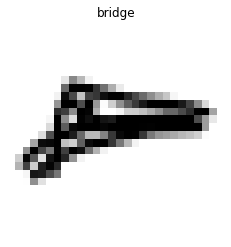

In [21]:
for item in train.take(1):
    plt.imshow(item[0].numpy().reshape(28, 28), cmap='gray_r')
    plt.title(str(class_list[item[1].numpy()]))
    plt.axis("off")

Here we prepare the datasets for training, and then train and evaluate the model.

In [22]:
train = train.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test = test.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val = val.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train = train.shuffle(500).repeat().batch(32) # shuffle() helps with overfitting
test = test.batch(32)  
val = val.batch(32)

In [23]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=10, kernel_size=4, strides=2, padding="valid", input_shape=[None, 1]),    
    keras.layers.GRU(20),
    keras.layers.Dense(len(class_list), activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [24]:
# keras.utils.plot_model(model, show_shapes=True)

In [25]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [26]:
history = model.fit(train, epochs=10, validation_data=val, 
                    steps_per_epoch=int(train_size / 32), validation_steps=int(val_size / 32),
                    callbacks=[early_stopping_cb])

Epoch 1/10
15136/15136 [==============================] - 275s 18ms/step - loss: 0.6153 - accuracy: 0.7695 - val_loss: 0.3765 - val_accuracy: 0.8753
Epoch 2/10
15136/15136 [==============================] - 205s 14ms/step - loss: 0.3506 - accuracy: 0.8837 - val_loss: 0.3242 - val_accuracy: 0.8925
Epoch 3/10
15136/15136 [==============================] - 205s 14ms/step - loss: 0.3106 - accuracy: 0.8984 - val_loss: 0.2883 - val_accuracy: 0.9079
Epoch 4/10
15136/15136 [==============================] - 204s 13ms/step - loss: 0.2862 - accuracy: 0.9072 - val_loss: 0.2917 - val_accuracy: 0.9090
Epoch 5/10
15136/15136 [==============================] - 204s 14ms/step - loss: 0.2998 - accuracy: 0.9026 - val_loss: 0.6584 - val_accuracy: 0.7623
Epoch 6/10
15136/15136 [==============================] - 204s 13ms/step - loss: 0.2903 - accuracy: 0.9061 - val_loss: 0.2628 - val_accuracy: 0.9152
Epoch 7/10
15136/15136 [==============================] - 203s 13ms/step - loss: 0.2634 - accuracy: 0.9153

In [27]:
model.evaluate(test)

3244/3244 [==============================] - 28s 9ms/step - loss: 0.2163 - accuracy: 0.9305


[0.21632571518421173, 0.9304797053337097]

# Etude 2 - Generating Bach-like Music

Download the Bach chorales dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note’s index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on.

Let's create the list of files of each dataset type (training, test, validation).

In [28]:
dataset_dir_2 = os.path.join(os.getcwd(), "dataset_chorales")

# create new directory
if not os.path.isdir(dataset_dir_2):
    os.mkdir(dataset_dir_2)

In [29]:
DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/"
FILENAME = "jsb_chorales.tgz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir=os.path.join(dataset_dir_2),
                                extract=True)

In [30]:
train_dataset_dir = os.path.join(dataset_dir_2, "train")
test_dataset_dir = os.path.join(dataset_dir_2, "test")
valid_dataset_dir = os.path.join(dataset_dir_2, "valid")

In [31]:
train_dataset_list = [os.path.join(train_dataset_dir, file) for file in os.listdir(train_dataset_dir) 
                      if os.path.isfile(os.path.join(train_dataset_dir, file))]
test_dataset_list = [os.path.join(test_dataset_dir, file) for file in os.listdir(test_dataset_dir) 
                      if os.path.isfile(os.path.join(test_dataset_dir, file))]
valid_dataset_list = [os.path.join(valid_dataset_dir, file) for file in os.listdir(valid_dataset_dir) 
                      if os.path.isfile(os.path.join(valid_dataset_dir, file))]

Let's prepare some test chorales so that we can use them as an input to our network.

In [32]:
def load_chorales(filepaths):
    """"Prepares the list of chorales"""
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

chorales_to_test = load_chorales(train_dataset_list)

Now let's write the function that takes the list of paths of all datasets and creates the list of unique notes in all of them.

In [33]:
def list_of_unique_notes(*path_lists):
    """Determines the number of unique notes used in the dataset."""
    paths = []
    for path_list in path_lists:
        paths.append(path_list)
    
    chorales = []
    for file in sum(paths, []): # sum() flattens the list of paths, since initially we get [[],[],[]]
        chorale = np.loadtxt(file, delimiter=',', skiprows=1, dtype='int64').reshape(-1)
        chorales.append(chorale)
    all_notes = np.concatenate(chorales).ravel() 
    return np.unique(all_notes)

In [34]:
unique_notes = list_of_unique_notes(train_dataset_list)
num_classes = len(unique_notes)

In [35]:
unique_notes

array([ 0, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81])

Now let's create the indices for our vocabulary (where we will convert each note into an index).

In [36]:
indices = tf.range(num_classes, dtype=tf.int64)

Now we create the vocabulary of notes and their corresponding indices.

In [37]:
table_init = tf.lookup.KeyValueTensorInitializer(unique_notes, indices, key_dtype='int64', value_dtype='int64')
table_notes = tf.lookup.StaticVocabularyTable(table_init, 1)

In [38]:
table_notes.lookup(tf.constant(81, dtype='int64'))

<tf.Tensor: shape=(), dtype=int64, numpy=46>

Now we must prepare the dataset for training. To do this, we take each CSV file and then convert it into the flat list of note indexes. Then we create the features and labels of the specified length where labels are shifted by one note as compared to features.

In [39]:
SEQUENCE_LENGTH = 64
BATCH_SIZE = 32

In [40]:
def split_X_y(batch):
    """Splits the batch into label and target."""
    X = batch[:-1]
    y = batch[1:]
    return tf.cast(X, 'float32'), tf.cast(y, 'float32'), 

In [41]:
def stack_notes(dataset):
    """Stacks four tensors (one for each note) into a single tensor; each note is converted into the vocab index."""
    dataset = dataset.map(lambda col1, col2, col3, col4: tf.reshape(tf.stack(
        [table_notes.lookup(col1), table_notes.lookup(col2), table_notes.lookup(col3), table_notes.lookup(col4)]), [4, 1]))
    return dataset

In [42]:
def prepare_dataset(dataset_list, sequence_length, n_repeats):
    """Converts the list of CSV files into a dataset."""
    ds = tf.data.Dataset.list_files(dataset_list) # create the list of CSV files
    ds = ds.map(lambda x: tf.data.experimental.CsvDataset(x, [tf.int64 for i in range(4)], header=True)) # convert each CSV to dataset
    ds = ds.flat_map(stack_notes) # converts chords from four tensors of size 1 to one tensor of size 4 and returns the tensor (without _map - returns the dataset)
    
    # to flatten, map should return the dataset, so in this ds every element is just a tensor of shape 1
    # tf.Tensor([72.], shape=(1,), dtype=float32)
    ds = ds.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x)) 
          
    # we repeat the dataset specified number of times and split it into windows shifted by 12 notes
    # this will allow us to create a large enough dataset
    ds = ds.repeat(n_repeats).window(sequence_length+1, shift=16, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(sequence_length+1))
    # ds = ds.map(lambda x: tf.squeeze(x))
    ds = ds.map(split_X_y) # splits each batch into X and y
    return ds

Let's prepare the datasets.

In [43]:
train_ds = prepare_dataset(train_dataset_list, SEQUENCE_LENGTH, 3)
test_ds = prepare_dataset(test_dataset_list, SEQUENCE_LENGTH, 1)
valid_ds = prepare_dataset(valid_dataset_list, SEQUENCE_LENGTH, 1)

In [44]:
# for item in train_ds.take(1):
#     print(item)

Now we split the  dataset into batches and then create the model.

In [45]:
# split the dataset into the batches for the RNN
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.batch(BATCH_SIZE)

In [46]:
model = keras.models.Sequential([
    keras.layers.Embedding(len(unique_notes)+1, 5),
    keras.layers.GRU(256, dropout=0.3, return_sequences=True),
    keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Let's check our model.

In [47]:
for input_example_batch, target_example_batch in train_ds.take(1):
    print(input_example_batch.shape, "# input shape")
    print(target_example_batch.shape, "# output shape")
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# prediction shape (batch_size, number_of_classes_the_note_belogs_to)")
    # print("\n# prediction 0 - probabilities of classes \n", example_batch_predictions[0])

(32, 64, 1) # input shape
(32, 64, 1) # output shape
(32, 64, 47) # prediction shape (batch_size, number_of_classes_the_note_belogs_to)


Now let's train the model and evaluate it.

In [48]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model.fit(train_ds, epochs=30, validation_data=valid_ds,
          callbacks=[early_stopping_cb])

Epoch 1/30
1295/1295 [==============================] - 27s 21ms/step - loss: 1.7768 - accuracy: 0.4798 - val_loss: 1.0591 - val_accuracy: 0.7104
Epoch 2/30
1295/1295 [==============================] - 11s 9ms/step - loss: 1.0632 - accuracy: 0.6956 - val_loss: 0.8979 - val_accuracy: 0.7537
Epoch 3/30
1295/1295 [==============================] - 11s 9ms/step - loss: 0.9265 - accuracy: 0.7323 - val_loss: 0.8100 - val_accuracy: 0.7774
Epoch 4/30
1295/1295 [==============================] - 11s 9ms/step - loss: 0.8344 - accuracy: 0.7554 - val_loss: 0.7713 - val_accuracy: 0.7859
Epoch 5/30
1295/1295 [==============================] - 11s 9ms/step - loss: 0.7296 - accuracy: 0.7779 - val_loss: 0.6702 - val_accuracy: 0.8030
Epoch 6/30
1295/1295 [==============================] - 11s 9ms/step - loss: 0.6591 - accuracy: 0.7958 - val_loss: 0.6277 - val_accuracy: 0.8161
Epoch 7/30
1295/1295 [==============================] - 11s 9ms/step - loss: 0.5894 - accuracy: 0.8153 - val_loss: 0.6033 - val_a

In [49]:
model.evaluate(test_ds)

148/148 [==============================] - 3s 18ms/step - loss: 0.6064 - accuracy: 0.8227


[0.6064459681510925, 0.8226607441902161]

Let's use the function kindly provided by the author of the book that will allow us to play the chords.

In [50]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # Frequency doubles when you go up one octave; there are 12 semi-tones
    # per octave; Note A on octave 4 is 440 Hz, and it is note number 69.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # the tempo is measured in beats per minutes
    # To reduce click sound at every beat, we round the frequencies to try to
    # get the samples close to zero at the end of each note.
    frequencies = np.round(note_duration * frequencies) / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # Removing all notes with frequencies ≤ 9 Hz (includes note 0 = silence)
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # make last note a bit longer
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # fade out last note
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

Let's play the test chorale to check whether the function works.

In [51]:
play_chords(chorales_to_test[3], filepath="test.wav")

Output hidden; open in https://colab.research.google.com to view.

Now we should write the function that would take the sequence of notes, predict the next note, and then use this note to predict another note and so on until the specified number of generated notes is reached. We can use the argmax function to determine the most probable note, but this can lead to the situation when the model becomes stuck in a loop (since it may generate the same two notes - note 1, note 2, note 1, note 2 and so on). Thereby, we need to generate output samples from the output destribution produced by the softmax activation function.

In [52]:
# we sum the nested lists to flatten the chorales and take first 32 notes
SAMPLE_STARTING_NOTES = sum(chorales_to_test[3], [])[:8]
 
NUMBER_OF_NOTES_TO_GENERATE = 112

In [53]:
def generate_chorale_sampled(number_of_notes_to_generate, starting_notes):
    """Generates a chorale using sampling."""
    # convert notes to vocabulary indices and expands to shape (1, num_notes, 1)
    note_idx = [table_notes.lookup(tf.cast(note, tf.int64)) for note in starting_notes]
    note_idx = tf.reshape(note_idx, [-1, 1])
       
    for i in range(number_of_notes_to_generate):
        # predicts next note index and generates new sample from distiribution
        prediction = model.predict(note_idx)

        # generate new sample and prepare it for the model        
        sample = tf.random.categorical(prediction[-1], num_samples=1)
        note_idx = tf.concat([note_idx, sample], axis=0)
    
    # convert note indexes back to notes
    notes = unique_notes[note_idx.numpy()]
    notes_flat = np.concatenate(notes).ravel().tolist()
    return [notes_flat[i:i+4] for i in range(0, len(notes), 4)]

In [54]:
def generate_chorale(number_of_notes_to_generate, starting_notes):
    """Generates a chorale using most probable class."""
    # convert notes to vocabulary indices and expands to shape (1, num_notes, 1)
    note_idx = [table_notes.lookup(tf.cast(note, tf.int64)) for note in starting_notes]
    note_idx = tf.reshape(note_idx, [-1, 1])
       
    for i in range(number_of_notes_to_generate):
        # predicts next note index and generates new sample from distiribution
        prediction = np.argmax(model.predict(note_idx), axis=-1)

        # generate new sample and prepare it for the model        
        note_idx = tf.concat([note_idx, tf.reshape(prediction[-1], [-1, 1]) ], axis=0)
    
    # convert note indexes back to notes
    notes = unique_notes[note_idx.numpy()]
    notes_flat = np.concatenate(notes).ravel().tolist()
    return [notes_flat[i:i+4] for i in range(0, len(notes), 4)]

In [55]:
sample_chorale = generate_chorale(NUMBER_OF_NOTES_TO_GENERATE, SAMPLE_STARTING_NOTES)
sample_chorale

[[74, 71, 67, 55],
 [74, 71, 67, 55],
 [67, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62],
 [62, 62, 62, 62]]

In [56]:
sample_chorale2 = generate_chorale_sampled(NUMBER_OF_NOTES_TO_GENERATE, SAMPLE_STARTING_NOTES)
sample_chorale2

[[74, 71, 67, 55],
 [74, 71, 67, 55],
 [41, 67, 77, 76],
 [55, 79, 43, 70],
 [45, 72, 39, 68],
 [40, 51, 79, 53],
 [56, 53, 59, 66],
 [51, 50, 72, 63],
 [67, 75, 54, 38],
 [62, 71, 81, 36],
 [38, 73, 60, 38],
 [71, 68, 37, 77],
 [45, 44, 56, 48],
 [73, 45, 38, 68],
 [79, 58, 73, 47],
 [57, 62, 49, 54],
 [66, 66, 55, 55],
 [78, 58, 55, 0],
 [75, 78, 53, 39],
 [44, 81, 70, 81],
 [69, 66, 68, 72],
 [80, 55, 71, 43],
 [68, 61, 62, 76],
 [67, 50, 76, 61],
 [55, 67, 66, 52],
 [0, 81, 70, 54],
 [49, 67, 41, 71],
 [42, 40, 42, 56],
 [64, 51, 43, 68],
 [57, 71, 64, 48]]

In [57]:
play_chords(sample_chorale, filepath="result.wav")

In [58]:
play_chords(sample_chorale2, filepath="result.wav")

Unfortunately, the result is terrible! ) This is probably due to the fact that we need to consider the structure of the chord. When we do not use sampling, we end up with the same repeating chord; when we use sampling, we end up with chords that are too random.
There may be several solutions that we can eventually try: we can either try to improve the model by using, for example, small WaveNet-like neural network composed of a stack of Conv1D layers, or we can try to predict not notes, but chords.